In [1]:
import pandas as pd
import numpy as np

In [15]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

/Users/ADI/anaconda/envs/dlWorks/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [70]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [3]:
df=pd.read_csv("data.csv")
print(df.shape)
df.head()

(2373, 5)


date day.of.week  car.count  weather cloud.indicator
0  2010-01-01      Friday        101      0.1           clear
1  2010-01-02    Saturday         34      0.2          cloudy
2  2010-01-03      Sunday        113      0.4           clear
3  2010-01-04      Monday          5      0.6          cloudy
4  2010-01-05     Tuesday        124      0.1           clear

Based on the structure of the dataset, I expect to observe a time series of data with noise added due to the cloud factor. I also expect to see some correlation and trends of number of cars with the weather condition and days of the week. To check all these hypotheses, I do some exploratory analysis below

## Exploratory Analysis

#### To check basic trends and distributions in the data across different features. 

car.count      weather
count  2373.000000  2373.000000
mean    112.773704     0.008512
std      50.127710     1.007344
min       0.000000    -3.200000
25%      81.000000    -0.700000
50%     122.000000     0.000000
75%     152.000000     0.700000
max     239.000000     4.300000

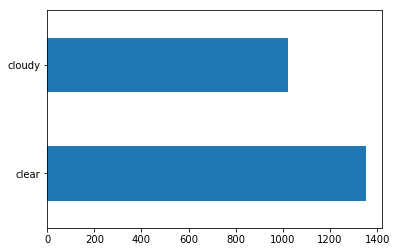

In [4]:
df['cloud.indicator'].value_counts().plot(kind="barh")
df.describe()

<b> Checking the number of missing and uniques values: <br></b>
There seems to be no explicitly missing values in the data. 

In [5]:
pd.concat([df.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          df.apply(lambda x: len(np.unique(x))).rename("num_unique")],axis=1)

num_missing  num_unique
date                       0        2373
day.of.week                0           7
car.count                  0         210
weather                    0          66
cloud.indicator            0           2

Exploring the trend of car counts over time: <br>
The chart does see to show some trend and periodicity. However, I sense potentially large noise in the data and therefore, check the trend for both cloudy and clear days separately.


In [6]:
trace = go.Scatter(x=df['date'], y=df['car.count'])
py.iplot([trace])

From the plot below, we can clearly see that there is a significant difference between observed car counts for cloudy and clear days. If we just focus on the clear days, we see a relatively cleaner time series distribution. This motivates me to explore the two types of cloud days as two different time series.

In [7]:
trace1=go.Scatter(x=df.loc[df['cloud.indicator']=='clear', 'date'], y=df.loc[df['cloud.indicator']=='clear', 'car.count'],  name='clear')
trace2=go.Scatter(x=df.loc[df['cloud.indicator']=='cloudy', 'date'], y=df.loc[df['cloud.indicator']=='cloudy', 'car.count'], name='cloudy')
py.iplot([trace1, trace2])

Checking the box plot distribution of car counts across the two types brings out the contrast clearly, showing that the number of cars observed on a cloudy day are significantly lower.

In [8]:
trace1 = go.Box(
    y=df.loc[df['cloud.indicator']=='clear', 'car.count'], name="clear"
)
trace2 = go.Box(
    y=df.loc[df['cloud.indicator']=='cloudy', 'car.count'], name="cloudy"
)
data = [trace1, trace2]
py.iplot(data)

I wanted to check if the weather values also differ significantly across the two groups, but don't see any obvious difference between the two distributions

In [9]:
trace1 = go.Box(
    y=df.loc[df['cloud.indicator']=='clear', 'weather'], name="clear"
)
trace2 = go.Box(
    y=df.loc[df['cloud.indicator']=='cloudy', 'weather'], name="cloudy"
)
data = [trace1, trace2]
py.iplot(data)

I also check the distribution of the number of cars across days of the week, to see if their is a marked difference across different days i.e. some periodicity in the data. No single day clearly stands out, however, Wednesday does seem to have most of the observations on the lower end of the median observation.

In [10]:
traces=[]
for i in df['day.of.week'].unique():
    trace = go.Box(y=df.loc[df['day.of.week']==i, 'car.count'], name=i)
    traces.append(trace)
py.iplot(traces)

I wished to check if their are any obvious correlations between the weather and the observed car count. However, no such correlation is suggested by the chart below and the pearson correlation coefficient. The difference between clear and cloudy days for number of cars is highlighted again here though.

In [17]:
scipy.stats.pearsonr(df['weather'], df['car.count'])

(0.0070403927398494087, 0.73175994778062292)

In [11]:
trace1=go.Scatter(x=df.loc[df['cloud.indicator']=='clear', 'weather'], y=df.loc[df['cloud.indicator']=='clear', 'car.count'], mode="markers", name='clear')
trace2=go.Scatter(x=df.loc[df['cloud.indicator']=='cloudy', 'weather'], y=df.loc[df['cloud.indicator']=='cloudy', 'car.count'], mode="markers", name='cloudy')
py.iplot([trace1, trace2])

## Modeling
Based on the exploratory analysis above, I plan to model the data as two separate time series - car count for clear days and car count for cloudy days as noise. For the clear days time series, the count of cars for the cloudy days is set to None and vice versa. To create a a consistent time series with regular time intervals, I impute the sythetically created missing data by linearly interpolating between the observed values. This divides our data into two distinct time series at a granularity of a day. I plan to fit a basic ARIMA model on both the time series individually by first decomposing it into trend, seasonal and residual components and then regressing on the residual component.

In [34]:
def timeSeriesDecomposition(series, df):
    
    """
        Decomposes the time series into three distinct components - trend, seasonality and residuals.
    """
    decomposition = seasonal_decompose(series)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid


    trace1 = go.Scatter(
            x=df.index, 
            y=df['car.count'], 
            name='Original',
    )
    trace2 = go.Scatter(
            x=df.index, 
            y=seasonal, 
            name='seasonal',
    )

    trace3 = go.Scatter(
            x=df.index, 
            y=trend, 
            name='trend',
    )

    trace4 = go.Scatter(
            x=df.index, 
            y=residual, 
            name='residual',
    )
    trace_arr=[trace1, trace2, trace3, trace4]
    residual.dropna(inplace=True)

    fig = go.Figure(data=trace_arr)
    py.iplot(fig)
    return trend,seasonal, residual

In [104]:
def plotACF_PACF(residual):
    """
        Calculating the autocorrelation function (ACF) and the parital autocorrelation function (PCF) 
        to determine the ideal value of the auto-regressive and moving average terms in 
        the ARIMA model- p and q respectively.
    """
    
    lag_acf = acf(residual, nlags=20)

    plt.figure(figsize=(10,6))
    plt.plot(lag_acf)
    plt.title('ACF')
    
    #Plot PACF:
    lag_pacf = pacf(residual, nlags=20, method='ols')
    
    plt.figure(figsize=(10,6))
    plt.plot(lag_pacf)
    plt.title('PCF')
    

In [26]:
def ARIMAmodel(residual, p, q):
    """
    Fitting the ARIMA model the residuals
    
    """
    model = ARIMA(residual, order=(p, 1, 0))  
    results_AR = model.fit(disp=-1)  
    return results_AR.fittedvalues

In [27]:
def createTimeSeriesDF(residual, seasonal, trend, fittedResiduals, original):
    """
    Creating a dataframe including all the components of the time series and calculating 
    the predicted values by the ARIMA model.
    """
    timeSeriesDF=pd.DataFrame({'residual':residual, 'seasonal':seasonal, 'trend':trend})
    timeSeriesDF['car.count']=original
    timeSeriesDF['fitted_residuals']=fittedResiduals
    timeSeriesDF['predicted']=timeSeriesDF['seasonal']+timeSeriesDF['trend']+timeSeriesDF['fitted_residuals']
    
    return timeSeriesDF

### Modeling car count for clear days 

In [28]:
dfClear=df.copy()
print(dfClear.shape)
dfClear.head()

(2373, 5)


date day.of.week  car.count  weather cloud.indicator
0  2010-01-01      Friday        101      0.1           clear
1  2010-01-02    Saturday         34      0.2          cloudy
2  2010-01-03      Sunday        113      0.4           clear
3  2010-01-04      Monday          5      0.6          cloudy
4  2010-01-05     Tuesday        124      0.1           clear

In [29]:
dfClear.loc[dfClear['cloud.indicator']=='cloudy', 'car.count']=None

In [30]:
pd.concat([dfClear.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          dfClear.apply(lambda x: len(np.unique(x))).rename("num_unique")],axis=1)

num_missing  num_unique
date                       0        2373
day.of.week                0           7
car.count               1020        1811
weather                    0          66
cloud.indicator            0           2

In [31]:
dfClear = dfClear.interpolate(method='linear', axis=0).ffill()
dfClear.head(20)
dfClear.index=pd.to_datetime(dfClear['date'])
del dfClear['date']

In [32]:
trace = go.Scatter(x=dfClear.index, y=dfClear['car.count'])
py.iplot([trace])

In [105]:
trend,seasonal, residual=timeSeriesDecomposition(dfClear['car.count'], dfClear)

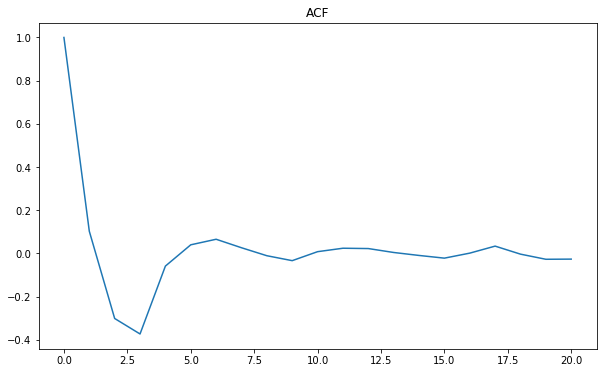

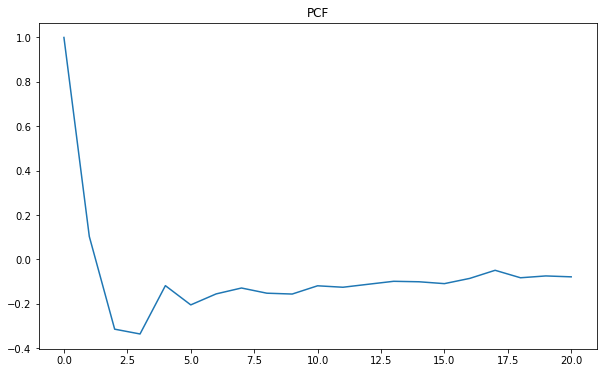

In [106]:
plotACF_PACF(residual)

In [39]:
fittedResiduals=ARIMAmodel(residual, 2, 2)

In [43]:
clear_timeSeriesDF=createTimeSeriesDF(residual, seasonal, trend, fittedResiduals, dfClear['car.count'])
clear_timeSeriesDF.dropna(inplace=True)
print('MSE - ', mean_squared_error(clear_timeSeriesDF['car.count'], clear_timeSeriesDF['predicted']))
clear_timeSeriesDF.head(10)


MSE -  164.680953121


residual  seasonal       trend  car.count  fitted_residuals  \
date                                                                       
2010-01-05  19.988193 -2.488193  106.500000      124.0         -0.006626   
2010-01-06  -1.337633 -2.305224  107.642857      104.0         -2.486588   
2010-01-07 -28.763747 -0.593395  110.357143       81.0          4.971281   
2010-01-08 -11.457440  1.028869  108.428571       98.0         15.664069   
2010-01-09   8.808796  2.048346  104.142857      115.0          1.610700   
2010-01-10  26.853214  1.718215  103.428571      132.0        -12.029491   
2010-01-11  -1.519954  0.591382  105.928571      105.0        -12.079664   
2010-01-12  -9.440378 -2.488193  105.928571       94.0          4.911339   
2010-01-13  -2.099538 -2.305224  103.404762       99.0         10.771520   
2010-01-14   0.736253 -0.593395   98.357143       98.5         -0.368586   

             predicted  
date                    
2010-01-05  104.005181  
2010-01-06  102.851045  
2010-01-07  114.735028  
2010-01-08  125.121510  
2010-01-09  107.801904  
2010-01-10   93.117295  
2010-01-11   94.440290  
2010-01-12  108.351717  
2010-01-13  111.871058  
2010-01-14   97.395162

In [44]:
# yp=model.predict(X_test)
trace1 = go.Scatter(y=clear_timeSeriesDF['car.count'], name="observed")
trace2 = go.Scatter(y=clear_timeSeriesDF['predicted'], name="predicted")
py.iplot([trace1, trace2])

As we see observe in the chart above, our ARIMA model predictions fit very well on the clear day time series with a mean absolute squared error of 164.68.

### Cloudy Modeling

In [45]:
dfCloudy=df.copy()
print(dfCloudy.shape)
dfCloudy.head()

(2373, 5)


date day.of.week  car.count  weather cloud.indicator
0  2010-01-01      Friday        101      0.1           clear
1  2010-01-02    Saturday         34      0.2          cloudy
2  2010-01-03      Sunday        113      0.4           clear
3  2010-01-04      Monday          5      0.6          cloudy
4  2010-01-05     Tuesday        124      0.1           clear

In [46]:
dfCloudy.loc[dfCloudy['cloud.indicator']=='clear', 'car.count']=None

In [47]:
dfCloudy = dfCloudy.interpolate(method='linear', axis=0).ffill().bfill()
dfCloudy.index=pd.to_datetime(dfCloudy['date'])
del dfCloudy['date']
dfCloudy.head(20)


day.of.week  car.count  weather cloud.indicator
date                                                      
2010-01-01      Friday      34.00      0.1           clear
2010-01-02    Saturday      34.00      0.2          cloudy
2010-01-03      Sunday      19.50      0.4           clear
2010-01-04      Monday       5.00      0.6          cloudy
2010-01-05     Tuesday      20.50      0.1           clear
2010-01-06   Wednesday      36.00     -0.1           clear
2010-01-07    Thursday      51.50     -1.0           clear
2010-01-08      Friday      67.00     -0.3          cloudy
2010-01-09    Saturday      89.00      0.2          cloudy
2010-01-10      Sunday      76.00      1.4           clear
2010-01-11      Monday      63.00     -0.1           clear
2010-01-12     Tuesday      50.00     -0.8           clear
2010-01-13   Wednesday      37.00     -0.5           clear
2010-01-14    Thursday      24.00      0.6          cloudy
2010-01-15      Friday      27.50     -1.9           clear
2010-01-16    Saturday      31.00     -0.6          cloudy
2010-01-17      Sunday      69.00      0.0          cloudy
2010-01-18      Monday      62.25      1.4           clear
2010-01-19     Tuesday      55.50     -0.9           clear
2010-01-20   Wednesday      48.75      0.0           clear

In [48]:
trace = go.Scatter(x=dfCloudy.index, y=dfCloudy['car.count'])
py.iplot([trace])

In [107]:
trend,seasonal, residual=timeSeriesDecomposition(dfCloudy['car.count'], dfCloudy)

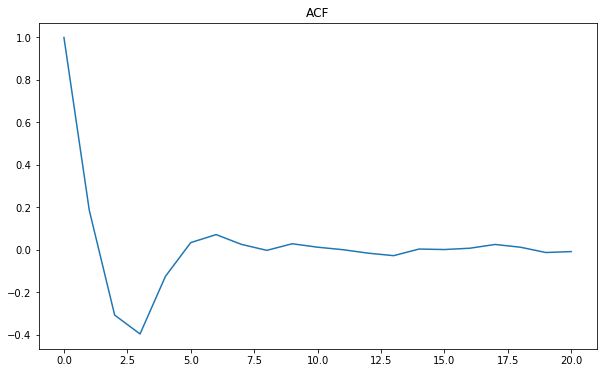

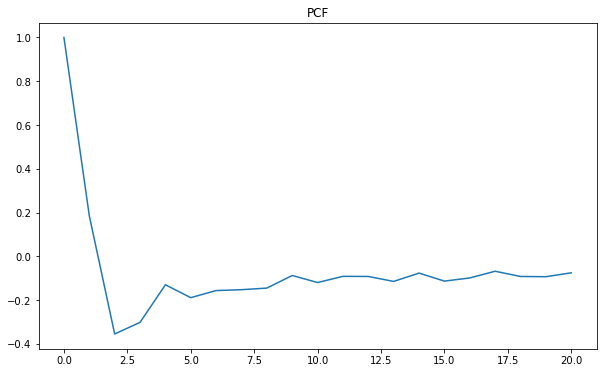

In [108]:
plotACF_PACF(residual)

In [109]:
fittedResiduals=ARIMAmodel(residual, p=2,q=2)

In [112]:
cloudy_timeSeriesDF=createTimeSeriesDF(residual, seasonal, trend, fittedResiduals, dfCloudy['car.count'])
cloudy_timeSeriesDF.dropna(inplace=True)
print('mse - ', mean_squared_error(cloudy_timeSeriesDF['car.count'], cloudy_timeSeriesDF['predicted']))
cloudy_timeSeriesDF.head(10)

mse -  924.93811309


residual  seasonal      trend  car.count  fitted_residuals  \
date                                                                      
2010-01-05 -13.567566  0.710423  33.357143       20.5          0.001606   
2010-01-06  -3.794015 -1.420270  41.214286       36.0         -2.154637   
2010-01-07   4.813709 -2.599423  49.285714       51.5         -5.761632   
2010-01-08  11.797808 -2.369237  57.571429       67.0         -5.118024   
2010-01-09  24.689006  2.525280  61.785714       89.0         -4.354333   
2010-01-10  11.772864  2.298565  61.928571       76.0         -5.383189   
2010-01-11   4.145337  0.854663  58.000000       63.0         -0.534369   
2010-01-12  -3.067566  0.710423  52.357143       50.0          5.809383   
2010-01-13  -5.651158 -1.420270  44.071429       37.0          4.125539   
2010-01-14 -16.472005 -2.599423  43.071429       24.0          2.815984   

            predicted  
date                   
2010-01-05  34.069172  
2010-01-06  37.639379  
2010-01-07  40.924659  
2010-01-08  50.084167  
2010-01-09  59.956661  
2010-01-10  58.843947  
2010-01-11  58.320294  
2010-01-12  58.876949  
2010-01-13  46.776697  
2010-01-14  43.287990

In [111]:
# yp=model.predict(X_test)
trace1 = go.Scatter(y=cloudy_timeSeriesDF['car.count'], name="observed")
trace2 = go.Scatter(y=cloudy_timeSeriesDF['predicted'], name="predicted")
py.iplot([trace1, trace2])

The ARIMA model for cloudy days seems to do a relatively fine job, however, the MSE observed is higher - 924.94

## Measure of Cloudiness

Since we have created interpolated time series for each of the two categories - Cloudy and Clear days. We can get a measure of cloudiness by taking the ratio between the two series on the cloudy days.

In [92]:
df.index=pd.to_datetime(df['date'])
del df['date']
df['clear_carCount']=dfClear['car.count']
df['cloudy_carCount']=dfCloudy['car.count']
df['cloudiness']=0
df.loc[df['cloud.indicator']=='cloudy',  'cloudiness']=df['clear_carCount']/df['cloudy_carCount']
df.head()

day.of.week  car.count  weather cloud.indicator  clear_carCount  \
date                                                                         
2010-01-01      Friday        101      0.1           clear           101.0   
2010-01-02    Saturday         34      0.2          cloudy           107.0   
2010-01-03      Sunday        113      0.4           clear           113.0   
2010-01-04      Monday          5      0.6          cloudy           118.5   
2010-01-05     Tuesday        124      0.1           clear           124.0   

            cloudy_carCount  cloudiness  
date                                     
2010-01-01             34.0    0.000000  
2010-01-02             34.0    3.147059  
2010-01-03             19.5    0.000000  
2010-01-04              5.0   23.700000  
2010-01-05             20.5    0.000000

In [99]:
trace1 = go.Scatter(x=df.index, y=df['car.count'], name="Car Count")
trace2 = go.Scatter(x=df.index, y=df['cloudiness'], name ="Cloudiness")
py.iplot([trace1, trace2])

In [96]:
trace = go.Scatter(x=df['cloudiness'], y=df['car.count'], mode="markers")
py.iplot([trace])

From the charts above we can observe that the high cloudiness peaks occur on days when the number of cars observed were way too low as compared to expected cars observed on a clear day.<br>
Also, from the scatter plot between number of cars observed vs cloudiness, we can see the clear negative correalation between the two.

### <b> What additional analysis might be useful if you had a whole day to work on the problem? </b>

<p>Given more time, I would work on an LSTM based recurrent neural net (RNN) model for modeling the time series data. It would help me also take into account the weather associated changes in the number of cars, while learning the temporal relationship in the data. </p>

<p>I would also look into identifying outlier days where the number of cars were much more or less than the expected (predicted) number.

<p> I would also look into additional imputatation methods other than the basic linear interpolation used for this analysis.
